In [108]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score as nnmi
from sklearn.metrics import adjusted_rand_score as ari
import sys
sys.path.append("/home/alex/Documents/InformationHeuristic/")
from src.datasets.datasets import mnist_dataset

In [109]:
_,_,full_dataset = mnist_dataset('/home/alex/Documents/InformationHeuristic/data/mnist')
labels = []
for i in range(len(full_dataset)):
    labels.append(full_dataset[i][1])
labels = np.array(labels)

In [110]:
#bt_lamb = ['1.20', '1.60', '2.13', '2.83', '3.76', '5.00', '6.65', '8.84', '11.76', '15.65', '20.81']
temps = [0.2 , 0.23, 0.26, 0.3 , 0.35, 0.4 , 0.46, 0.53, 0.61, 0.7,0.81,0.93]
num_copies = 3
temps = [f"{temp*1000:.2f}" for temp in temps]
pred_cube = np.zeros((len(temps),10,num_copies,70000))
eval_cube = np.zeros((len(temps),10,num_copies))
lamb_range = np.arange(3,13)
k_range = np.arange(10,11)
for i, lamb in enumerate(temps):
    pred_dict = torch.load(f"/home/alex/Documents/InformationHeuristic/weights/mnist/augmentation_clustering/iic_aug/iic_aug_simclr_r18_{lamb}/pred_dict.pt")
    nmi_dict = torch.load(f"/home/alex/Documents/InformationHeuristic/weights/mnist/augmentation_clustering/iic_aug/iic_aug_simclr_r18_{lamb}/nmi_scores.pt")
    #swap all the keys of the dictionary to be a tuple of ints
    new_pred_dict = {}
    new_eval_dict = {}
    for key in pred_dict.keys():
        new_key = tuple(int(x) for x in key)
        new_pred_dict[new_key] = pred_dict[key]
    for key in nmi_dict.keys():
        new_key = tuple(int(x) for x in key)
        new_eval_dict[new_key] = nmi_dict[key] 
    pred_dict = new_pred_dict
    nmi_dict = new_eval_dict

    for j,lamb_val in enumerate(lamb_range):
        for k,k_val in enumerate(range(num_copies)):
            pred_cube[i,j,k] = pred_dict[(lamb_val,10,k_val)].numpy()
            eval_cube[i,j,k] = nmi_dict[(lamb_val,10,k_val)]
            

        

In [111]:
pred_dict.keys()

dict_keys([(3, 10, 0), (3, 10, 1), (3, 10, 2), (4, 10, 0), (4, 10, 1), (4, 10, 2), (5, 10, 0), (5, 10, 1), (5, 10, 2), (6, 10, 0), (6, 10, 1), (6, 10, 2), (7, 10, 0), (7, 10, 1), (7, 10, 2), (8, 10, 0), (8, 10, 1), (8, 10, 2), (9, 10, 0), (9, 10, 1), (9, 10, 2), (10, 10, 0), (10, 10, 1), (10, 10, 2), (11, 10, 0), (11, 10, 1), (11, 10, 2), (12, 10, 0), (12, 10, 1), (12, 10, 2)])

In [112]:
pred_cube.shape

(12, 10, 3, 70000)

In [113]:
I,J,K,_ = pred_cube.shape

from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.metrics import mutual_info_score as mi
stab_cube = np.zeros((I,J,K))
eval_smooth = np.zeros((I,J,K))
from tqdm import tqdm
for i in tqdm(range(I)):
    for j in range(J):
        for k in range(K):
            counter = 0
            eval_smooth[i,j,k] = eval_cube[i,j,k]
            if i==0:
                stab_cube[i,j,k] += nmi(pred_cube[i,j,k],pred_cube[i+1,j,k])
                counter += 1
                eval_smooth[i,j,k] += eval_cube[i+1,j,k]
            elif i==I-1:
                stab_cube[i,j,k] += nmi(pred_cube[i,j,k],pred_cube[i-1,j,k])
                counter += 1
                eval_smooth[i,j,k] += eval_cube[i-1,j,k]
            else:
                stab_cube[i,j,k] += nmi(pred_cube[i,j,k],pred_cube[i+1,j,k])
                stab_cube[i,j,k] += nmi(pred_cube[i,j,k],pred_cube[i-1,j,k])
                counter += 2
                eval_smooth[i,j,k] += eval_cube[i+1,j,k]+eval_cube[i-1,j,k]
            if j == 0:
                stab_cube[i,j,k] += nmi(pred_cube[i,j,k],pred_cube[i,j+1,k])
                counter += 1
                eval_smooth[i,j,k] += eval_cube[i,j+1,k]
            elif j == J-1:
                stab_cube[i,j,k] += nmi(pred_cube[i,j,k],pred_cube[i,j-1,k])
                counter += 1
                eval_smooth[i,j,k] += eval_cube[i,j-1,k]
            else:
                stab_cube[i,j,k] += nmi(pred_cube[i,j,k],pred_cube[i,j+1,k])
                stab_cube[i,j,k] += nmi(pred_cube[i,j,k],pred_cube[i,j-1,k])
                counter += 2
                eval_smooth[i,j,k] += eval_cube[i,j+1,k]+eval_cube[i,j-1,k]
            
            eval_smooth[i,j,k] += eval_cube[i,j,k_1]+eval_cube[i,j,k_2]
            stab_cube[i,j,k] /= counter
            eval_smooth[i,j,k] /= (counter+1)

100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


In [77]:
#define self_cube where only nmi to neighbours
self_cube = np.zeros((I,J,K))
for i in range(I):
    for j in range(J):
        for k in range(K):
            if k == 0:
                k_1 = 1
                k_2 = 2
            elif k == 1:
                k_1 = 0
                k_2 = 2
            else:
                k_1 = 0
                k_2 = 1
            self_cube[i,j,k] += nmi(pred_cube[i,j,k],pred_cube[i,j,k_1]) + nmi(pred_cube[i,j,k],pred_cube[i,j,k_2])
            self_cube[i,j,k] /= 2

In [114]:
stab_cube.shape,eval_cube.shape

((12, 10, 3), (12, 10, 3))

<Axes: >

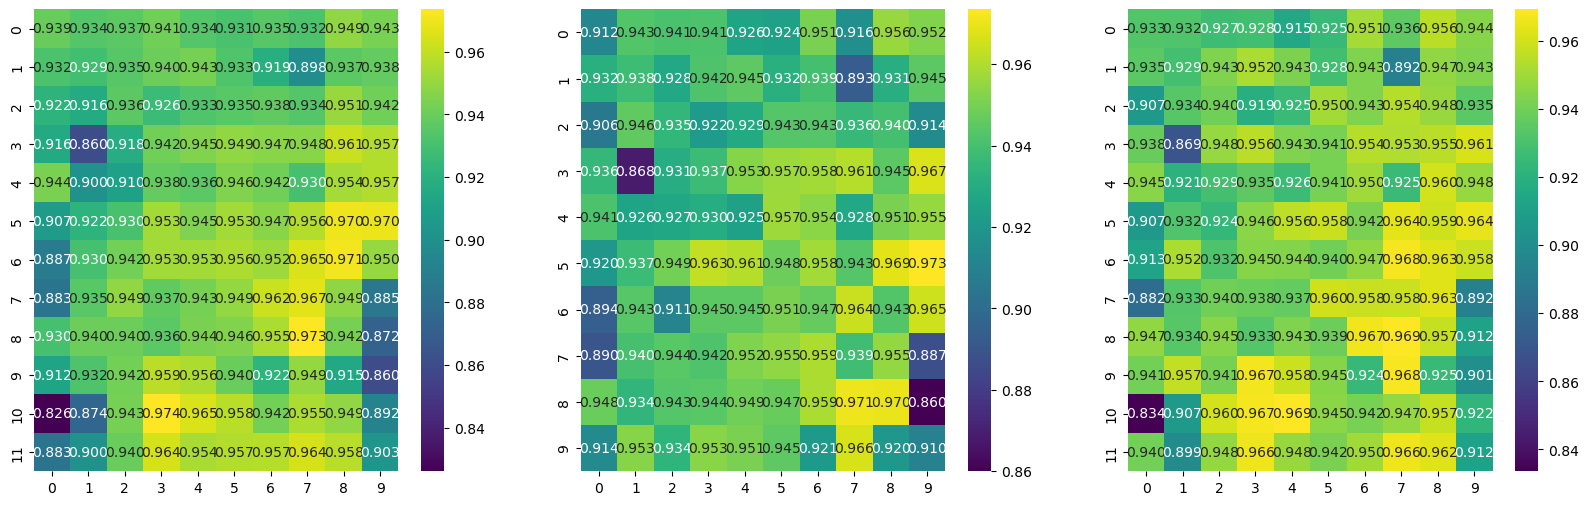

In [115]:
f,a = plt.subplots(1,3,figsize=(20,6))
import seaborn as sns
i=2
sns.heatmap(stab_cube[:,:,i],ax=a[0],annot=True,cmap='viridis',fmt='.3f')
sns.heatmap(self_cube[:,:,i],ax=a[1],annot=True,cmap='viridis',fmt='.3f')
sns.heatmap(eval_cube[:,:,i],ax=a[2],annot=True,cmap='viridis',fmt='.3f')

In [116]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def hungarian_match(y_pred, y_true):
    """
    Map predicted cluster labels to ground truth labels using Hungarian algorithm.
    
    Args:
        y_pred: Predicted cluster labels (array-like)
        y_true: Ground truth labels (array-like)
    
    Returns:
        y_pred_mapped: Predicted labels mapped to ground truth label space
        mapping: Dictionary mapping original predicted labels to ground truth labels
    """
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Use Hungarian algorithm to find optimal assignment
    # We want to maximize the sum, so we use negative cost matrix
    row_ind, col_ind = linear_sum_assignment(-cm)
    
    # Create mapping from predicted labels to true labels
    mapping = {col_ind[i]: row_ind[i] for i in range(len(col_ind))}
    
    # Apply mapping to predicted labels
    y_pred_mapped = np.array([mapping.get(label, label) for label in y_pred])
    
    return y_pred_mapped, mapping




In [121]:
#find the argmax in stab_cube (i,j,k)
i,j,k = np.unravel_index(np.argmax(eval_cube),eval_cube.shape)
y_mapped,mapping = hungarian_match(pred_cube[i,j,k],labels)
print(f"Accuracy after Hungarian matching: {np.mean(y_mapped == labels):.4f}")

Accuracy after Hungarian matching: 0.9891


In [104]:
y_mapped,mapping = hungarian_match(pred_cube[8,7,2],labels)

In [107]:
(y_mapped==labels).mean()

0.9891571428571428

In [86]:
np.corrcoef(stab_cube.flatten(),eval_cube.flatten()),np.corrcoef(self_cube.flatten(),eval_cube.flatten())

(array([[1.        , 0.81399476],
        [0.81399476, 1.        ]]),
 array([[1.        , 0.76416625],
        [0.76416625, 1.        ]]))

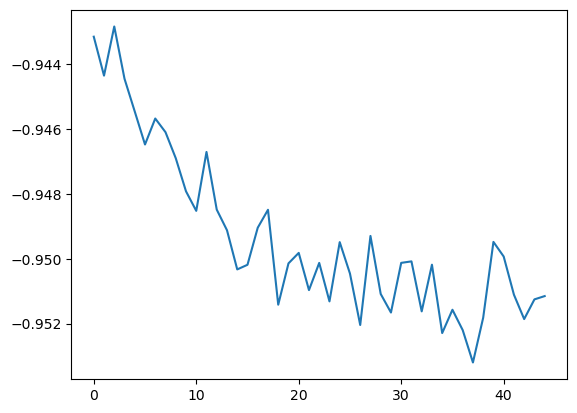

In [85]:
loss_dict = torch.load(f"/home/alex/Documents/InformationHeuristic/weights/mnist/augmentation_clustering/iic_aug/iic_aug_bt_r18_1.20/loss_dict.pt")

In [89]:
from itertools import product 
product(range(10),range(8),range(7))

In [91]:
0.2*1.15**np.arange(0,13)

array([0.2       , 0.23      , 0.2645    , 0.304175  , 0.34980125,
       0.40227144, 0.46261215, 0.53200398, 0.61180457, 0.70357526,
       0.80911155, 0.93047828, 1.07005002])